In [1]:
from hcipy import *
from stgp_util_32 import *
import h5py

import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import scipy.ndimage as ndimage
import scipy
import time
import os

folder_name = '16x16_sn1002'

filepath = 'matrix_for_GP_16x16.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

# the full phase matrix
mask_phase8 = arrays["mask_phase8"]

M2P = arrays["M2P"]
M2P = M2P.transpose().astype(np.float32)


wavelength_wfs = 0.5e-6 

G8 = arrays["G_8"]
G8 = G8.transpose().astype(np.float32)
G_recon = G8
SH_grid8 = get_non_empty_column_indices(G8)
G8 = G8[:,SH_grid8]

n_history = 5
A8          = scipy.linalg.block_diag(*([G8] * n_history))
A8          = np.concatenate((A8, np.zeros((A8.shape[0], 1 * G_recon.shape[1]))),1).astype(np.float32)

act_pix = G_recon.shape[1]
n_pixels = 16*8
mask_phase8 = arrays["mask_phase8"]

(xvalid, yvalid) = np.nonzero(mask_phase8)

vec_to_im    = vec_to_img(n_pixels, xvalid, yvalid)
im_to_vec    = img_to_vec(xvalid, yvalid)

filepath = 'dm2.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

M2P_dm = arrays["M2P_dm"]
M2P = M2P_dm.transpose().astype(np.float32)

In [2]:
# Load matrices
#Cff_np1 = np.load(os.path.join(folder_name, 'Cff_np1.npy'))
#Cff_np2 = np.load(os.path.join(folder_name, 'Cff_np2.npy'))
#Cff_np4 = np.load(os.path.join(folder_name, 'Cff_np4.npy'))
#Cff_np6 = np.load(os.path.join(folder_name, 'Cff_np6.npy'))
#Cff_np8 = np.load(os.path.join(folder_name, 'Cff_np8.npy'))
#Cwaff_np8 = np.load(os.path.join(folder_name, 'Cff_np8.npy'))


#Cff8  = np.load(os.path.join(folder_name, 'Cff8.npy'))
Cs_np = np.load(os.path.join(folder_name, 'Cs_np.npy'))
Chol_ff = np.load(os.path.join(folder_name, 'Chol_ff.npy'))

u = np.load(os.path.join(folder_name, 'u.npy'))

# Load matrices
Rs = np.load(os.path.join(folder_name, 'Rs.npy'))
Rff1 = np.load(os.path.join(folder_name, 'Rff1.npy'))
Rff2 = np.load(os.path.join(folder_name, 'Rff22.npy'))
Rff4 = np.load(os.path.join(folder_name, 'Rff4.npy'))
Rff6 = np.load(os.path.join(folder_name, 'Rff6.npy'))
Rff8 = np.load(os.path.join(folder_name, 'Rff8.npy'))


Rwaff1 = np.load(os.path.join(folder_name, 'Rwaff1.npy'))
Rwaff2 = np.load(os.path.join(folder_name, 'Rwaff2.npy'))
Rwaff4 = np.load(os.path.join(folder_name, 'Rwaff4.npy'))
Rwaff6 = np.load(os.path.join(folder_name, 'Rwaff6.npy'))
Rwaff8 = np.load(os.path.join(folder_name, 'Rwaff8.npy'))


noise_var = np.load(os.path.join(folder_name, 'noise_var.npy'))

In [3]:

# sample data and ground truth
#Chol_ff = np.linalg.cholesky(Cff8 + 1e-8*np.diag(np.random.randn(Cff8.shape[0])))
Phi     = np.matmul(Chol_ff, np.random.normal(0,1,Chol_ff.shape[0]))
slopes = A8 @ Phi + np.sqrt(noise_var)*np.random.normal(0,1,A8.shape[0]) 

In [4]:
noise_var

array(0.00059383)

In [5]:

u_crop      = u.copy()
u_crop[:,0] = 0

# mean vectors
mu_ff1   = Rff1   @ slopes
mu_ff2   = Rff2   @ slopes
mu_ff4   = Rff4   @ slopes
mu_ff6   = Rff6   @ slopes
mu_ff8   = Rff8   @ slopes

mu_s    = Rs @ slopes[-G_recon.shape[0]:]

# remove piston

mu_ff1   = u_crop @ u.transpose() @ mu_ff1[-act_pix:]
mu_ff2   = u_crop @ u.transpose() @ mu_ff2[-act_pix:]
mu_ff4   = u_crop @ u.transpose() @ mu_ff4[-act_pix:]
mu_ff6   = u_crop @ u.transpose() @ mu_ff6[-act_pix:]
mu_ff8   = u_crop @ u.transpose() @ mu_ff8[-act_pix:]


mu_s    = u_crop @ u.transpose() @ mu_s
ground_truth = u_crop @ u.transpose() @ Phi[-act_pix:]


In [6]:
# mean vectors
mu_waff1   = Rwaff1   @ slopes
mu_waff2   = Rwaff2   @ slopes
mu_waff4   = Rwaff4   @ slopes
mu_waff6   = Rwaff6   @ slopes
mu_waff8   = Rwaff8   @ slopes

mu_s    = Rs @ slopes[-G_recon.shape[0]:]

mu_waff1   = u_crop @ u.transpose() @ mu_waff1[-act_pix:]
mu_waff2   = u_crop @ u.transpose() @ mu_waff2[-act_pix:]
mu_waff4   = u_crop @ u.transpose() @ mu_waff4[-act_pix:]
mu_waff6   = u_crop @ u.transpose() @ mu_waff6[-act_pix:]
mu_waff8   = u_crop @ u.transpose() @ mu_waff8[-act_pix:]

In [7]:
constant = ((wavelength_wfs / (2 * np.pi)) * 1e6)

fig, axs = plt.subplots(3,3,figsize = (10.4,8.3))
im1 = axs[0][0].imshow(vec_to_im(mu_ff1)*constant)
plt.colorbar(im1, ax=axs[0][0])
axs[0][0].axis(False)
axs[0][0].set_title('FF-GP mean vector, s = 1')

im3 = axs[0][1].imshow(vec_to_im(mu_ff2)*constant)
axs[0][1].axis(False)
axs[0][1].set_title('FF-GP mean vector, s = 2')

im3 = axs[0][2].imshow(vec_to_im(mu_ff4)*constant)
plt.colorbar(im3, ax=axs[0][2])
axs[0][2].axis(False)
axs[0][2].set_title('FF-GP mean vector, s = 4')

im3 = axs[1][0].imshow(vec_to_im(mu_ff6)*constant)
axs[1][0].axis(False)
axs[1][0].set_title('FF-GP mean vector, s = 6')

im3 = axs[1][1].imshow(vec_to_im(mu_ff8)*constant)
axs[1][1].axis(False)
axs[1][1].set_title('FF-GP mean vector, s = 8')

im2 = axs[1][2].imshow(vec_to_im(mu_s)*constant)
plt.colorbar(im2, ax=axs[1][2])
axs[1][2].axis(False)
axs[1][2].set_title('S-GP mean vector')

im4 = axs[2][0].imshow(vec_to_im(ground_truth)*constant)
plt.colorbar(im4, ax=axs[2][0])
axs[2][0].axis(False)
axs[2][0].set_title('ground truth')


axs[2][1].axis('off') 

axs[2][2].axis('off') 

#plt.show()

(0.0, 1.0, 0.0, 1.0)

In [8]:
#number of modes
n_modes = 224  
P2M = np.linalg.pinv(M2P[:,0:n_modes])

ff1_recon = M2P[:,0:n_modes] @ P2M @ mu_ff1 
ff2_recon = M2P[:,0:n_modes] @ P2M @ mu_ff2 
ff4_recon = M2P[:,0:n_modes] @ P2M @ mu_ff4
ff6_recon = M2P[:,0:n_modes] @ P2M @ mu_ff6 
ff8_recon = M2P[:,0:n_modes] @ P2M @ mu_ff8

waff1_recon = M2P[:,0:n_modes] @ P2M @ mu_waff1 
waff2_recon = M2P[:,0:n_modes] @ P2M @ mu_waff2 
waff4_recon = M2P[:,0:n_modes] @ P2M @ mu_waff4 
waff6_recon = M2P[:,0:n_modes] @ P2M @ mu_waff6
waff8_recon = M2P[:,0:n_modes] @ P2M @ mu_waff8

s_recon   = M2P[:,0:n_modes] @ P2M @ mu_s  
o_recon   = M2P[:,0:n_modes] @ P2M @ ground_truth

<IPython.core.display.Javascript object>


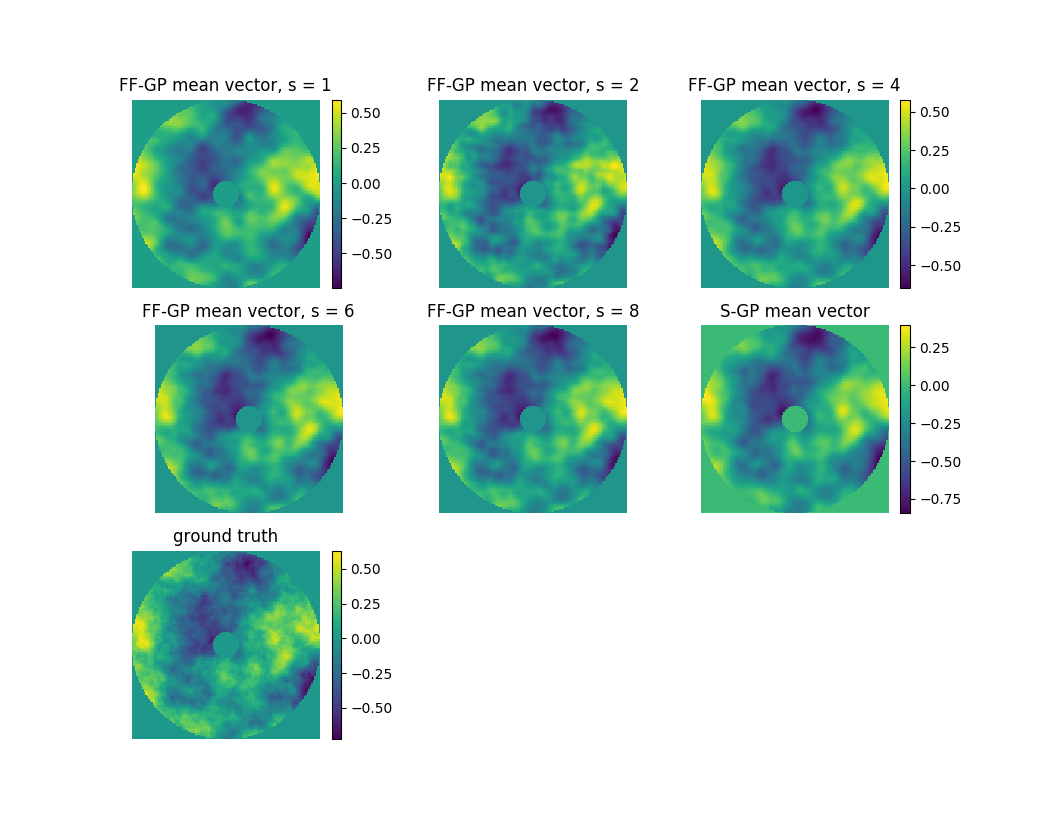

<IPython.core.display.Javascript object>


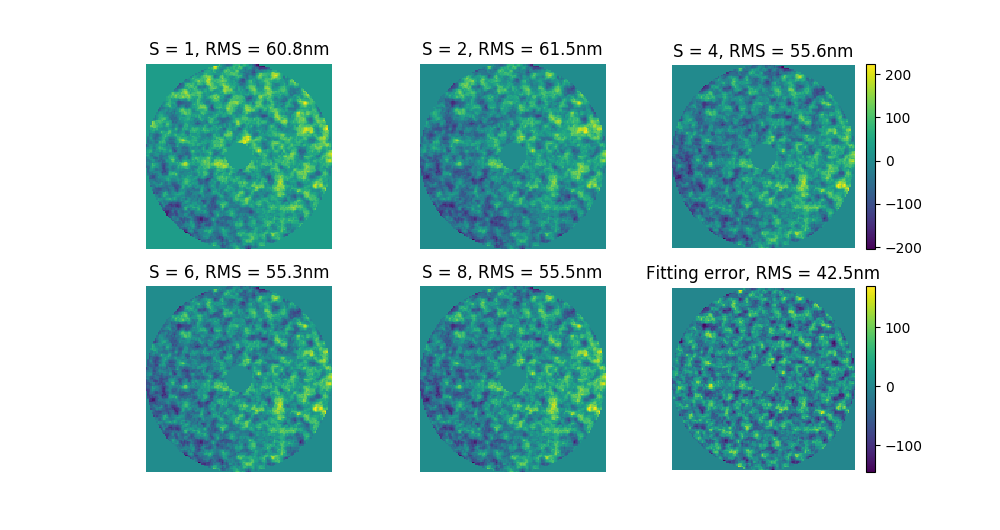

In [9]:
constant = ((wavelength_wfs / (2 * np.pi)) * 1e9)

# Update subplot titles with the variable x
fig, axs = plt.subplots(2, 3, figsize=(10, 5.3))
im1 = axs[0][0].imshow(vec_to_im(ff1_recon - ground_truth) * constant)
axs[0][0].axis(False)
axs[0][0].set_title(f'S = 1, RMS = {round(np.sqrt(np.mean(((ff1_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[0][1].imshow(vec_to_im(ff2_recon*2- ground_truth) * constant)
axs[0][1].axis(False)
axs[0][1].set_title(f'S = 2, RMS = {round(np.sqrt(np.mean(((ff2_recon*2- ground_truth)*constant)**2)),1)}nm')

im3 = axs[0][2].imshow(vec_to_im(ff4_recon - ground_truth) * constant)
plt.colorbar(im3, ax=axs[0][2])
axs[0][2].axis(False)
axs[0][2].set_title(f'S = 4, RMS = {round(np.sqrt(np.mean(((ff4_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[1][0].imshow(vec_to_im(ff6_recon - ground_truth) * constant)
axs[1][0].axis(False)
axs[1][0].set_title(f'S = 6, RMS = {round(np.sqrt(np.mean(((ff6_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[1][1].imshow(vec_to_im(ff8_recon - ground_truth) * constant)
axs[1][1].axis(False)
axs[1][1].set_title(f'S = 8, RMS = {round(np.sqrt(np.mean(((ff8_recon- ground_truth)*constant)**2)),1)}nm')

im2 = axs[1][2].imshow(vec_to_im(o_recon - ground_truth) * constant)
plt.colorbar(im2, ax=axs[1][2])
axs[1][2].axis(False)
axs[1][2].set_title(f'Fitting error, RMS = {round(np.sqrt(np.mean(((o_recon- ground_truth)*constant)**2)),1)}nm')

plt.savefig('MC_example_ff.pdf')
# Show the figure
plt.show()

#plt.title('f model: T= %d' % (t))

<IPython.core.display.Javascript object>


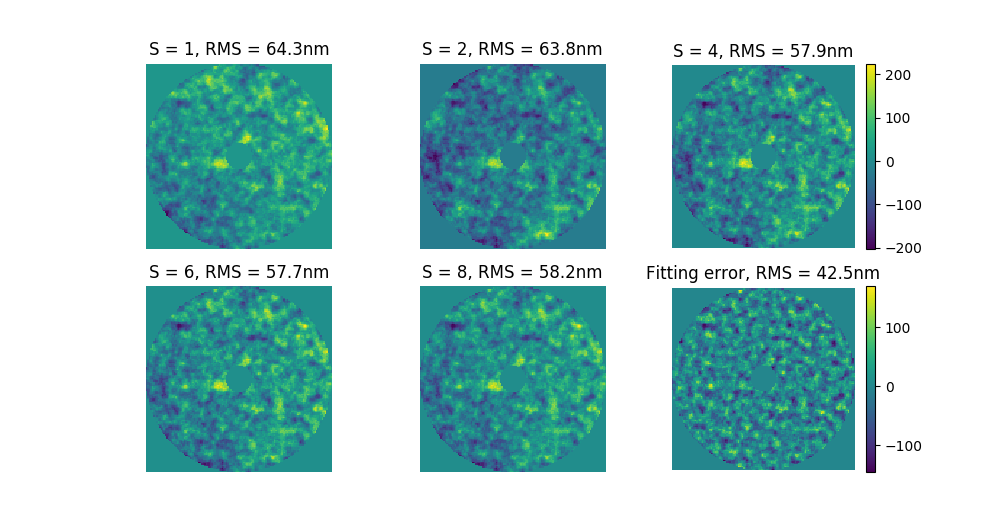

In [10]:
constant = ((wavelength_wfs / (2 * np.pi)) * 1e9)

# Update subplot titles with the variable x
fig, axs = plt.subplots(2, 3, figsize=(10, 5.3))
im1 = axs[0][0].imshow(vec_to_im(waff1_recon - ground_truth) * constant)
axs[0][0].axis(False)
axs[0][0].set_title(f'S = 1, RMS = {round(np.sqrt(np.mean(((waff1_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[0][1].imshow(vec_to_im(waff2_recon - ground_truth) * constant)
axs[0][1].axis(False)
axs[0][1].set_title(f'S = 2, RMS = {round(np.sqrt(np.mean(((waff2_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[0][2].imshow(vec_to_im(waff4_recon - ground_truth) * constant)
plt.colorbar(im3, ax=axs[0][2])
axs[0][2].axis(False)
axs[0][2].set_title(f'S = 4, RMS = {round(np.sqrt(np.mean(((waff4_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[1][0].imshow(vec_to_im(waff6_recon - ground_truth) * constant)
axs[1][0].axis(False)
axs[1][0].set_title(f'S = 6, RMS = {round(np.sqrt(np.mean(((waff6_recon- ground_truth)*constant)**2)),1)}nm')

im3 = axs[1][1].imshow(vec_to_im(waff8_recon - ground_truth) * constant)
axs[1][1].axis(False)
axs[1][1].set_title(f'S = 8, RMS = {round(np.sqrt(np.mean(((waff8_recon- ground_truth)*constant)**2)),1)}nm')

im2 = axs[1][2].imshow(vec_to_im(o_recon - ground_truth) * constant)
plt.colorbar(im2, ax=axs[1][2])
axs[1][2].axis(False)
axs[1][2].set_title(f'Fitting error, RMS = {round(np.sqrt(np.mean(((o_recon- ground_truth)*constant)**2)),1)}nm')

# Save the figure
plt.savefig('output_figure.png', bbox_inches='tight')

plt.savefig('MC_example_waff.pdf')
# Show the figure
plt.show()

#plt.title('f model: T= %d' % (t))



In [11]:
print(np.sqrt(np.mean(((ff1_recon*1.0- ground_truth)*constant)**2)))
print(np.sqrt(np.mean(((ff2_recon*2- ground_truth)*constant)**2)))
print(np.sqrt(np.mean(((ff4_recon- ground_truth)*constant)**2)))
print(np.sqrt(np.mean(((ff6_recon- ground_truth)*constant)**2)))
print(np.sqrt(np.mean(((ff8_recon- ground_truth)*constant)**2)))
print(np.sqrt(np.mean(((s_recon- ground_truth)*constant)**2)))

print(np.sqrt(np.mean((( Phi[-act_pix:])*constant)**2)))
print(np.sqrt(np.mean((( Phi[-act_pix:] - o_recon)*constant)**2)))

60.78245272846234
61.52119740695269
55.55694610447165
55.284191269835006
55.4727439267464
205.9600207030946
262.3106158861986
91.03646361284169


<IPython.core.display.Javascript object>


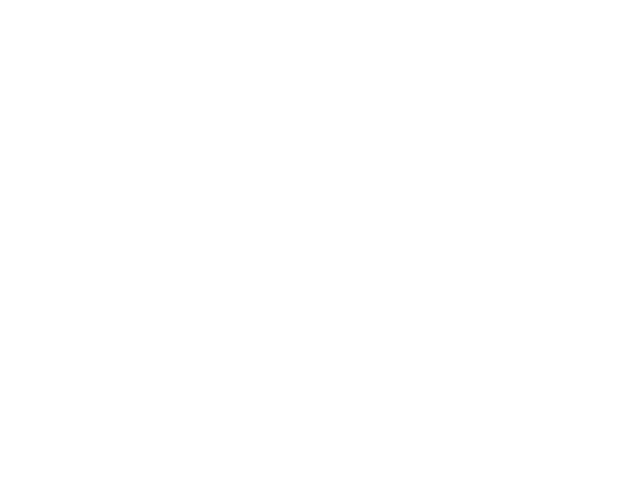

In [12]:
plt.savefig('relative_gain.pdf')
plt.show()